In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tabulate import tabulate
import scipy.stats as stats
from sklearn.metrics.pairwise import cosine_similarity

### Modify values in the following 3 cells as necessary

In [145]:
DataColName = "frequency"  # this is used as the data column name in output file

## parameters for generating data
# contributions of each signature, 
# entries in a dictionary
# values are relative sizes, will be normalized 
# provide either a single value or a 2-value tuple for min-max


#peaky
contributions = {
    "SBS1": 25,
    "SBS18": 10,
    "SBS32": 10,
    "SBS37": 5,
    "SBS39": 5
}

# specify number of variants in each data set ("sample")
variants = 200

# specify number of data sets to generate
num_data = 10

In [146]:
# specify COSMIC data file here
COSMIC_DATA_FILE = "COSMIC_v3.3.1_SBS_GRCh37.txt"

# loading COSMIC mutsig data
df_sig = pd.read_csv(COSMIC_DATA_FILE, sep="\t")
signatures = list(df_sig.columns[1:])
subs = df_sig.Type.values

In [147]:
def generate_data(num_variants, num_sets, contributions, ref_sigs):

    # datasets list
    datasets = []

    for n in range(num_sets):
        coeffs = {}
        for s_ in contributions:
            if type(contributions[s_]) in [tuple, list]:
                min_, max_ = contributions[s_]
                coeffs[s_] = min_ + (max_ - min_) * np.random.random()
            else:
                coeffs[s_] = contributions[s_]
        total = sum(coeffs.values())

        # build die
        weights = np.zeros(96)
        for s_ in coeffs:
            c_ = coeffs[s_] / total
            weights += c_ * ref_sigs[s_].values

        # build data
        data = np.random.choice(np.arange(96), size=num_variants, replace=True, p=weights)
        
        # store dataset in list
        data_dic = {
            "substitution": subs,
            DataColName: [np.count_nonzero(data == i) for i in range(96)]
        }
        dataframe = pd.DataFrame(data_dic)

        # Calculate 'p' column
        dataframe['p'] = dataframe['frequency'] / dataframe['frequency'].sum()
        
        # Define the desired order list
        order_list = ['A[C>A]A', 'A[C>A]C', 'A[C>A]G', 'A[C>A]T', 'C[C>A]A', 'C[C>A]C', 'C[C>A]G', 'C[C>A]T', 'G[C>A]A', 'G[C>A]C', 'G[C>A]G', 'G[C>A]T', 'T[C>A]A', 'T[C>A]C', 'T[C>A]G', 'T[C>A]T', 'A[C>G]A', 'A[C>G]C', 'A[C>G]G', 'A[C>G]T', 'C[C>G]A', 'C[C>G]C', 'C[C>G]G', 'C[C>G]T', 'G[C>G]A', 'G[C>G]C', 'G[C>G]G', 'G[C>G]T', 'T[C>G]A', 'T[C>G]C', 'T[C>G]G', 'T[C>G]T', 'A[C>T]A', 'A[C>T]C', 'A[C>T]G', 'A[C>T]T', 'C[C>T]A', 'C[C>T]C', 'C[C>T]G', 'C[C>T]T', 'G[C>T]A', 'G[C>T]C', 'G[C>T]G', 'G[C>T]T', 'T[C>T]A', 'T[C>T]C', 'T[C>T]G', 'T[C>T]T', 'A[T>A]A', 'A[T>A]C', 'A[T>A]G', 'A[T>A]T', 'C[T>A]A', 'C[T>A]C', 'C[T>A]G', 'C[T>A]T', 'G[T>A]A', 'G[T>A]C', 'G[T>A]G', 'G[T>A]T', 'T[T>A]A', 'T[T>A]C', 'T[T>A]G', 'T[T>A]T', 'A[T>C]A', 'A[T>C]C', 'A[T>C]G', 'A[T>C]T', 'C[T>C]A', 'C[T>C]C', 'C[T>C]G', 'C[T>C]T', 'G[T>C]A', 'G[T>C]C', 'G[T>C]G', 'G[T>C]T', 'T[T>C]A', 'T[T>C]C', 'T[T>C]G', 'T[T>C]T', 'A[T>G]A', 'A[T>G]C', 'A[T>G]G', 'A[T>G]T', 'C[T>G]A', 'C[T>G]C', 'C[T>G]G', 'C[T>G]T', 'G[T>G]A', 'G[T>G]C', 'G[T>G]G', 'G[T>G]T', 'T[T>G]A', 'T[T>G]C', 'T[T>G]G', 'T[T>G]T']

        # Create a dictionary with numerical representation of the desired order
        order_dict = {v: i for i, v in enumerate(order_list)}

        # Create a new column 'Order' in the DataFrame based on the numerical representation
        dataframe['Order'] = dataframe['substitution'].map(order_dict)

        # Sort the DataFrame based on the 'Order' column
        dataframe = dataframe.sort_values(by='Order')

        # Reset the index
        dataframe = dataframe.reset_index(drop=True)

        # Drop the 'Order' column if not needed
        dataframe = dataframe.drop('Order', axis=1)
        datasets.append(dataframe)
    
    return datasets

In [148]:
gen_data = generate_data(variants, num_data, contributions, df_sig)


In [149]:
# Merge with 'ref_sigs' DataFrame
merged_df = pd.merge(gen_data[0], df_sig, left_on='substitution', right_on='Type')
    
# Drop unnecessary columns
ref_sig = merged_df.drop(columns=['substitution', 'frequency', 'p'])

#storing the substitutuion types for future use
types = ref_sig['Type']

In [170]:
#function to plot the mutational profile of a sample
def plot_sample(df):
    import matplotlib.patches as mpatches
    plt.figure(figsize=(20, 4))

    colors = []
    subs = df['substitution']
    subs = subs.str.extract('\[(.*?)\]', expand=False)    
    
    for substitution in subs:
        if substitution in ['C>A']:
            colors.append('blue')

        elif substitution in ['C>G']:
            colors.append('black')
        
        elif substitution in ['C>T']:
            colors.append('red')
            
        elif substitution in ['T>A']:
            colors.append('grey')
            
        elif substitution in ['T>C']:
            colors.append('green')
            
        else:
            colors.append('pink')
            
    
    plt.bar(df["substitution"], df["frequency"], color = colors, width = 0.6)
    plt.margins(x=0)
    plt.xticks(rotation=90)
    plt.xlabel('Substitution')
    plt.ylabel('Mutation Count')
    plt.title('Mutational substitution analysis', x=0.5, y=1.1)
    blue_patch = mpatches.Patch(color='blue', label='C>A')
    black_patch = mpatches.Patch(color='black', label='C>G')
    red_patch = mpatches.Patch(color='red', label='C>T')
    grey_patch = mpatches.Patch(color='grey', label='T>A')
    green_patch = mpatches.Patch(color='green', label='T>C')
    pink_patch = mpatches.Patch(color='pink', label='T>G')
    plt.legend(handles=[blue_patch, black_patch, red_patch, grey_patch, green_patch, pink_patch], labelcolor = ['blue', 'black', 'red', 'grey', 'green', 'pink'],
                ncol = 6, handlelength = 14, mode = "expand", bbox_to_anchor=(0, 1, 1, 0), loc = 'lower left')
    plt.show()

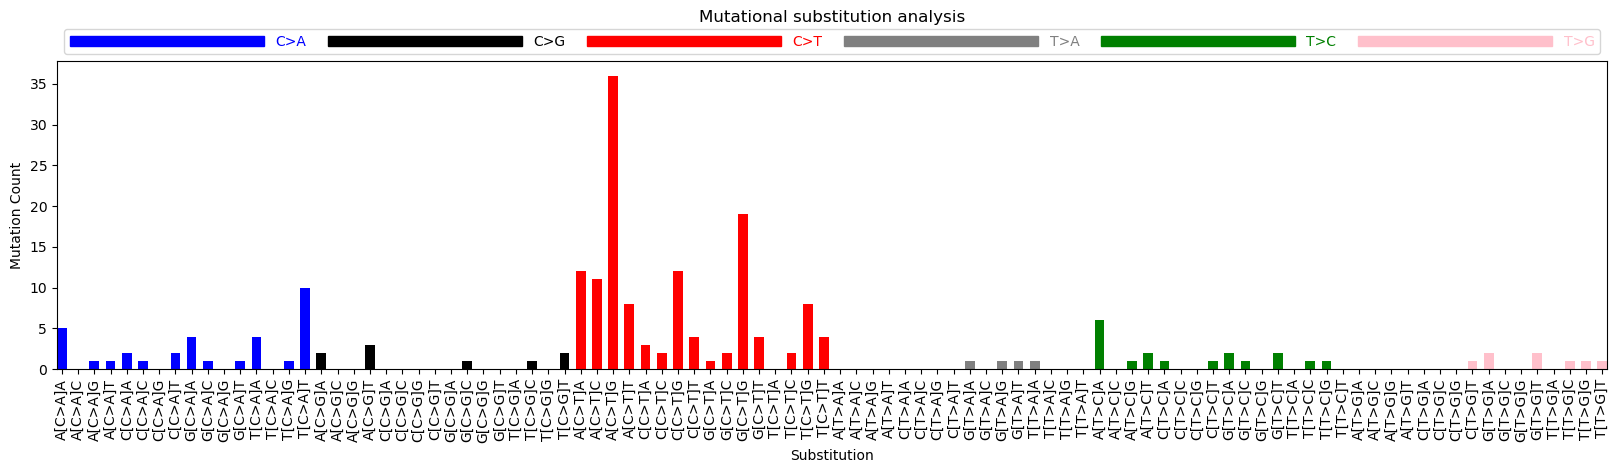

In [151]:
plot_sample(gen_data[5])

In [141]:
from scipy.stats import entropy

def calculate_entropy(sample):
    return entropy(sample['p'], base=2)
    
def get_peakiness(sample):
    return 1 / calculate_entropy(sample)

In [142]:
calculate_entropy(gen_data[5])

5.332058634944403

In [143]:
get_peakiness(gen_data[5])

0.18754482432851696

In [168]:
#flat
flat_contributions = {
    "SBS1": 1,
    "SBS18": 20,
    "SBS32": 2,
    "SBS37": 20,
    "SBS39": 20
}


gen_data = generate_data(variants, num_data, contributions, df_sig)

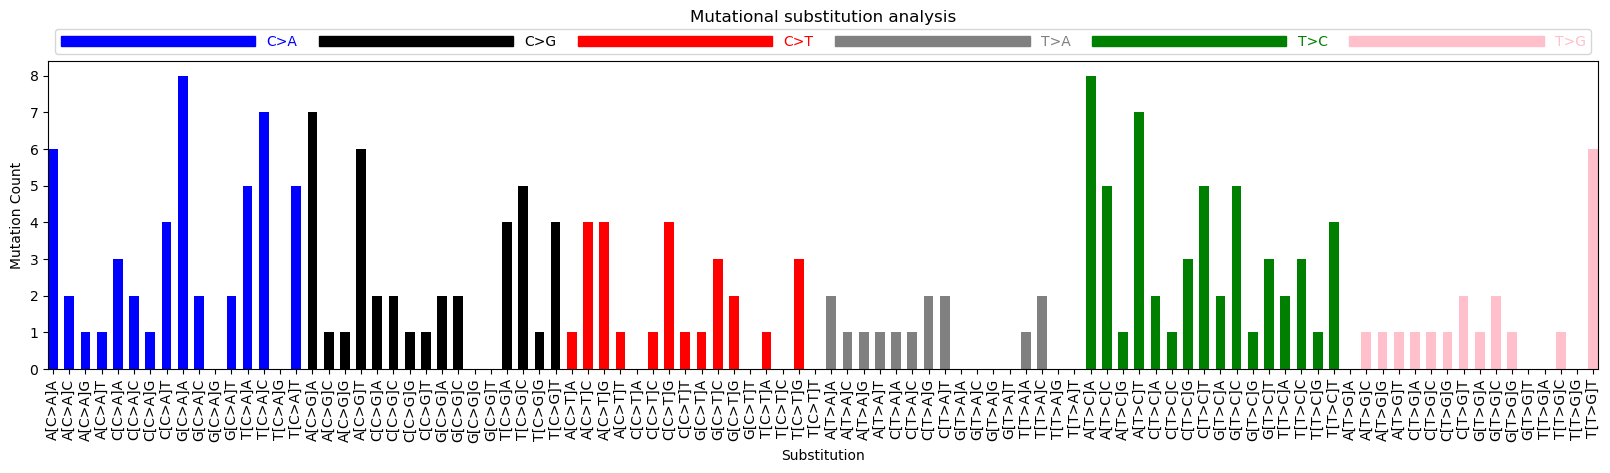

In [169]:
plot_sample(gen_data[5])

In [129]:
calculate_entropy(gen_data[5])

5.905190520577704

In [130]:
get_peakiness(gen_data[5])

0.16934254644542276